In [1]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from geomodel import geoModel, geoDataSet, epoch, geoDataSet2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
sns.set_theme()

/Users/btb/.virtualenvs/geospatial/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
batch_size = 512

dataset = geoDataSet2("data/labels.npy","data/features.npy")
number_samples = len(dataset)

train_dataset, test_dataset = random_split(dataset, [round(number_samples*0.8),number_samples-round(number_samples*0.8)])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

unique_points = dataset.label_count
context_size = dataset.context_size
embedding_dimension = 10
model = geoModel(unique_points+1, embedding_dimension, context_size)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1)

In [3]:
losses = ()
for i in range(0,3):
    losses = epoch(model, loss_function, optimizer, train_dataloader, test_dataloader=test_dataloader, model_save_path="model_save/model.pt")
# with torch.no_grad():
#     model.predict(dataset[1]["context"])

Log probs shape: torch.Size([512, 5743])
loss:  8.690314 | time 0.216218(s) | Batch [    0/    9]
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([498, 5743])
epoch 0 done | loss 57.495472 | time 1.907975(s)
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([124, 5743])
epoch 0 | test loss 9.640072
Log probs shape: torch.Size([512, 5743])
loss:  3.378972 | time 0.115898(s) | Batch [    0/    9]
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([512, 5743])
Log probs shape: torch.Size([

<AxesSubplot:xlabel='Epoch', ylabel='Test Loss'>

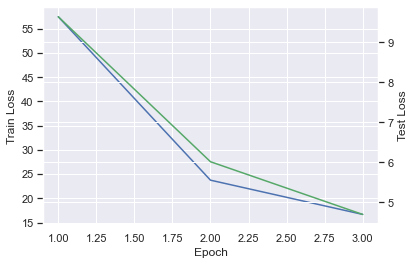

In [4]:
loss_df = pd.DataFrame({"Epoch":[i+1 for i in range(0,len(losses[0]))],"Train Loss":losses[0],"Test Loss":losses[1]})
loss_df["delta"] = loss_df["Train Loss"] - loss_df["Test Loss"]
sns.lineplot(data=loss_df[:],x="Epoch",y="Train Loss")
ax2 = plt.twinx()
sns.lineplot(data=loss_df[:],x="Epoch",y="Test Loss", color="g", ax=ax2)

In [6]:
model.predict(dataset[1:3]["context"]), model.predict(dataset[1]["context"])

Log probs shape: torch.Size([2, 5743])
Log probs shape: torch.Size([1, 5743])


(tensor([[-10.7489,  -9.5588, -13.4936,  ..., -14.0607, -14.4419, -14.7841],
         [ -9.8859, -10.5307, -13.3857,  ..., -14.8255, -14.4163, -13.8523]]),
 tensor([[-10.7489,  -9.5588, -13.4936,  ..., -14.0607, -14.4419, -14.7841]]))

In [10]:
dataset2 = geoDataSet2("data/labels.npy","data/features.npy")


In [15]:
model.predict(train_dataset[1:4]["context"])

Log probs shape: torch.Size([3, 5743])


tensor([[ -5.8706,  -5.7072, -10.4215,  ..., -11.2705, -11.2455, -11.6959],
        [ -6.2178,  -4.2211, -11.3665,  ..., -10.6212, -11.5752, -11.5416],
        [ -9.4087,  -7.3205, -13.3180,  ..., -13.6831, -13.7126, -13.6780]])

In [12]:
y.shape

torch.Size([1, 5743])